## Daniyarov Madiyar, Assylkhanov Yelaman
## SIS1

## 1. Установка и импорт библиотек
В этой секции подключаем все необходимые пакеты:  


In [1]:

import mlflow.sklearn
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)
import os

## 2. Датасет
- Загружаем данные 

       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.000000   
25%      

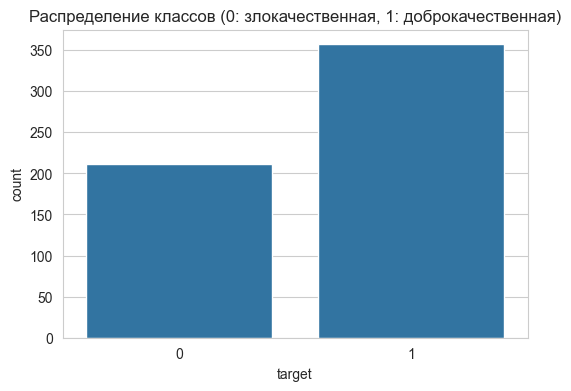

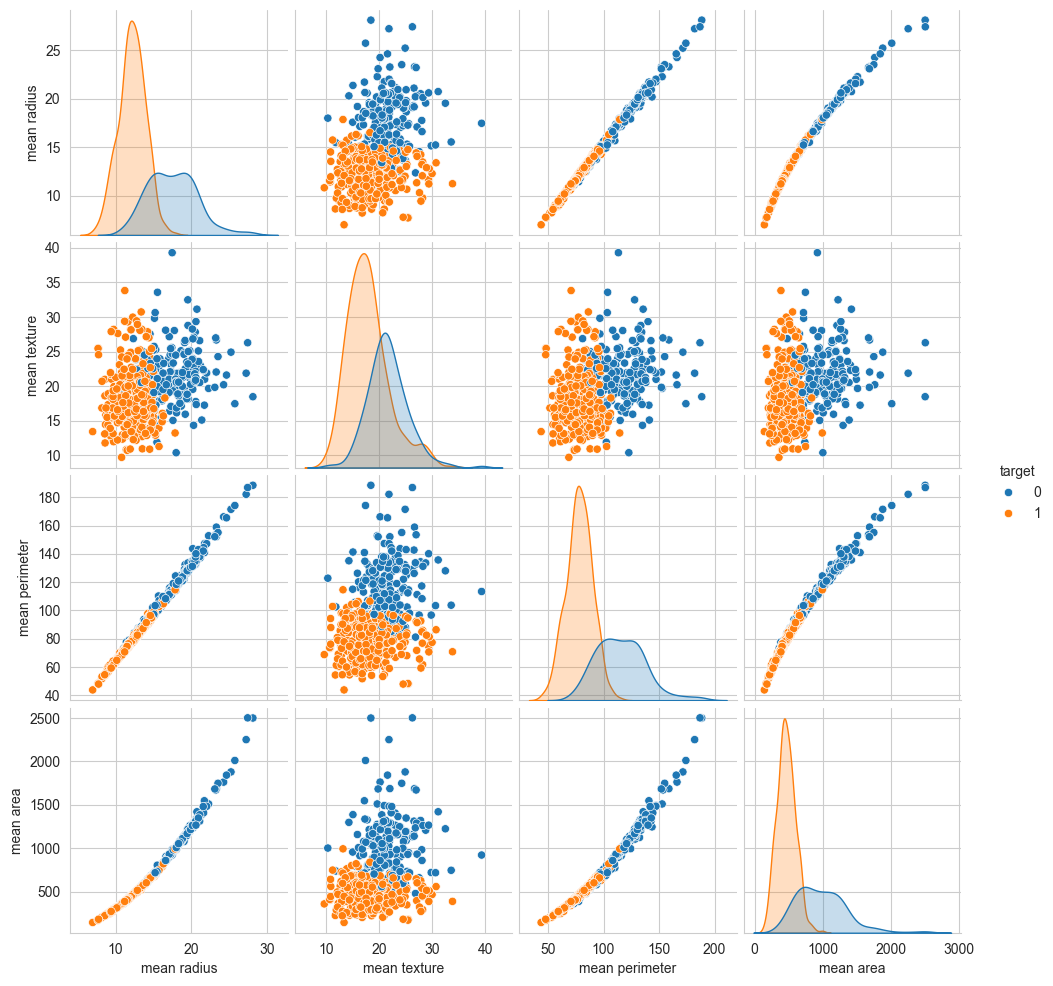

In [2]:
# Загрузка данных
data = load_breast_cancer(as_frame=True)
df = data.frame

# Визуализация распределения классов
plt.figure(figsize=(6, 4))
sns.countplot(x='target', data=df)
print(df.describe())
plt.title('Распределение классов (0: злокачественная, 1: доброкачественная)')
plt.show()

# Визуализация взаимосвязи признаков с помощью PairPlot (для 4-х признаков)
selected_features = ['mean radius', 'mean texture', 'mean perimeter', 'mean area']
sns.pairplot(df, vars=selected_features, hue='target')
plt.show()

- Разделяем на `train` и `test` 
- создаем mlflow experiment

In [3]:

os.makedirs("mlruns", exist_ok=True)
mlflow.set_experiment("SIS1")

# ==== Подготовка данных ====
X, y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

feature_names = load_breast_cancer().feature_names
input_example = pd.DataFrame(X_train[:5], columns=feature_names)

mlflow.sklearn.autolog(disable_for_unsupported_versions=True)


## 3. Метрики качества
Считаем и логируем в MLflow:
- Accuracy  
- Precision  
- Recall  
- F1-score  
- Macro, Micro, Weighted average  

In [4]:

# ==== Функция для логирования метрик и confusion matrix ====
def log_metrics_and_artifacts(model_name, y_true, y_pred, classes):
    # Метрики
    accuracy = accuracy_score(y_true, y_pred)
    precision_macro = precision_score(y_true, y_pred, average="macro")
    recall_macro = recall_score(y_true, y_pred, average="macro")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    precision_micro = precision_score(y_true, y_pred, average="micro")
    recall_micro = recall_score(y_true, y_pred, average="micro")
    f1_micro = f1_score(y_true, y_pred, average="micro")

    precision_weighted = precision_score(y_true, y_pred, average="weighted")
    recall_weighted = recall_score(y_true, y_pred, average="weighted")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("precision_macro", precision_macro)
    mlflow.log_metric("recall_macro", recall_macro)
    mlflow.log_metric("f1_macro", f1_macro)

    mlflow.log_metric("precision_micro", precision_micro)
    mlflow.log_metric("recall_micro", recall_micro)
    mlflow.log_metric("f1_micro", f1_micro)

    mlflow.log_metric("precision_weighted", precision_weighted)
    mlflow.log_metric("recall_weighted", recall_weighted)
    mlflow.log_metric("f1_weighted", f1_weighted)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {model_name}")

    # показать в ноутбуке
    plt.show()

    # сразу в MLflow без сохранения файла локально
    mlflow.log_figure(plt.gcf(), f"confusion_matrix_{model_name}.png")

    # очистка графика
    plt.close()


## 4. Обучение моделей
- Пробуем несколько алгоритмов (Logistic Regression, Decision Tree, Random Forest и т.д.)  
- Для каждой модели запускаем `mlflow.start_run()`  
- Логируем **гиперпараметры** и **метрики**  

2025/09/25 22:07:09 INFO mlflow.sklearn.utils: Logging the 5 best runs, 3 runs will be omitted.


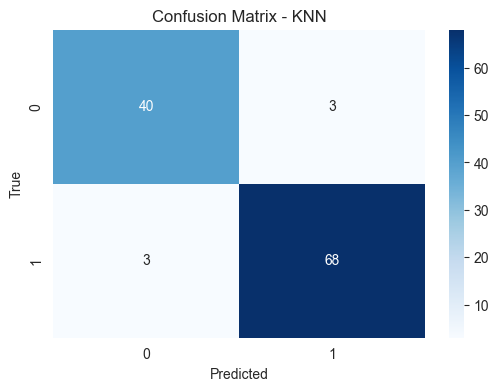

2025/09/25 22:07:09 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

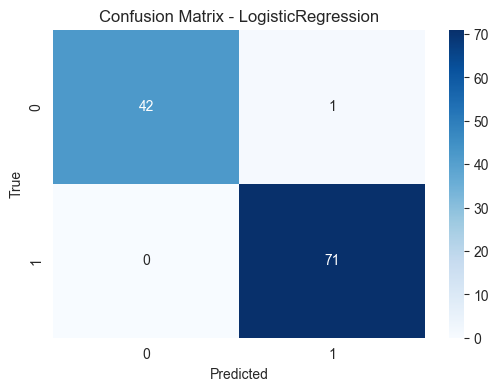

2025/09/25 22:07:24 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

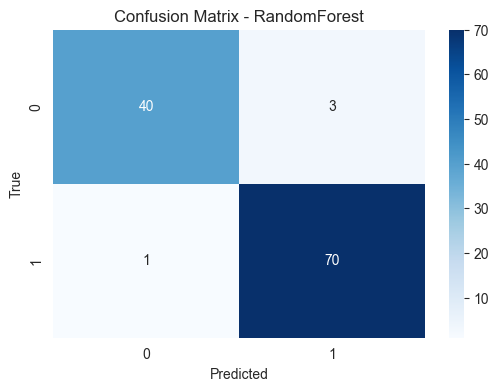

2025/09/25 22:07:54 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
C:\Python311\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
C:\Python311\Lib\site-packages\mlflow\types\utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.

✅ Все модели обучены и результаты загружены в MLflow. Запусти: mlflow ui


In [5]:

# ==== 1. KNN ====
with mlflow.start_run(run_name="KNN-Tuning"):
    pipe_knn = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', KNeighborsClassifier())
    ])

    param_grid_knn = {
        'classifier__n_neighbors': [3, 5, 7, 9],
        'classifier__weights': ['uniform', 'distance']
    }

    grid_search_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='accuracy')
    grid_search_knn.fit(X_train, y_train)

    mlflow.log_params(grid_search_knn.best_params_)
    mlflow.log_metric("best_score", grid_search_knn.best_score_)

    best_knn = grid_search_knn.best_estimator_
    y_pred_knn = best_knn.predict(X_test)
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred_knn))

    log_metrics_and_artifacts("KNN", y_test, y_pred_knn, classes=best_knn.classes_)

    mlflow.sklearn.log_model(best_knn, "knn_model", input_example=input_example)

# ==== 2. Logistic Regression ====
with mlflow.start_run(run_name="LogisticRegression-Tuning"):
    pipe_lr = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(random_state=42, max_iter=10000))
    ])

    param_grid_lr = {
        'classifier__C': [0.1, 1, 10, 100],
        'classifier__solver': ['liblinear', 'lbfgs']
    }

    grid_search_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='accuracy')
    grid_search_lr.fit(X_train, y_train)

    mlflow.log_params(grid_search_lr.best_params_)
    mlflow.log_metric("best_score", grid_search_lr.best_score_)

    best_lr = grid_search_lr.best_estimator_
    y_pred_lr = best_lr.predict(X_test)
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred_lr))

    log_metrics_and_artifacts("LogisticRegression", y_test, y_pred_lr, classes=best_lr.classes_)

    mlflow.sklearn.log_model(best_lr, "logistic_regression_model", input_example=input_example)

# ==== 3. Random Forest ====
with mlflow.start_run(run_name="RandomForest-Tuning"):
    pipe_rf = Pipeline([
        ('scaler', StandardScaler()),  # можно убрать, деревья не зависят от масштаба
        ('classifier', RandomForestClassifier(random_state=42))
    ])

    param_grid_rf = {
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [10, 20, None]
    }

    grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='accuracy')
    grid_search_rf.fit(X_train, y_train)

    mlflow.log_params(grid_search_rf.best_params_)
    mlflow.log_metric("best_score", grid_search_rf.best_score_)

    best_rf = grid_search_rf.best_estimator_
    y_pred_rf = best_rf.predict(X_test)
    mlflow.log_metric("test_accuracy", accuracy_score(y_test, y_pred_rf))

    log_metrics_and_artifacts("RandomForest", y_test, y_pred_rf, classes=best_rf.classes_)

    mlflow.sklearn.log_model(best_rf, "random_forest_model", input_example=input_example)

print("run mlflow ui in the current directory")
